# Persiapan Install Library

In [2]:
# --- INSTALL (Hanya jalan sekali, aman untuk dijalankan berulang) ---
!pip install --upgrade gensim numpy scipy --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 23.5 MB/s eta 0:00:00


In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.7 MB/s eta 0:00:00


In [4]:
# --- RESTART CHECKER ---
import os
import IPython

In [41]:
# General and Data Handling
import pandas as pd
import numpy as np
import re
import sys

# NLP Processing
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Deep Learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab Specific
from google.colab import drive
from google.colab import files

# Other Utilities
from scipy.sparse import hstack

In [6]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Data dari drive

In [7]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
# Load dataset
file_path = "/content/drive/My Drive/Belajar_pengembangam_ML/WA.csv"
data = pd.read_csv(file_path)

# Preprocessing

In [9]:
# Preprocessing teks
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [10]:
#clean
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\d+|[^\w\s]', ' ', text)
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

data['cleaned_review'] = data['content'].apply(clean_text)

In [11]:
# Mapping sentimen dan label
data['sentiment'] = data['score'].apply(lambda x: 'negatif' if x in [1, 2] else 'netral' if x == 3 else 'positif')
data['label'] = data['sentiment'].map({'negatif': 0, 'netral': 1, 'positif': 2})


In [12]:
# Normalisasi rating (0-1)
data['normalized_rating'] = data['score'] / 5.0

# Build model

## SKEMA 1: LogisticRegression + TF-IDF + Rating (80/20)

In [13]:
# SKEMA 1: LogisticRegression + TF-IDF + Rating (80/20)

# # Gabungkan teks dan rating sebagai fitur
data['text_with_rating'] = data['cleaned_review']


In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['text_with_rating'], data['label'],
    test_size=0.2, stratify=data['label'], random_state=42
)

In [15]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_text = tfidf.fit_transform(X_train)
X_test_text = tfidf.transform(X_test)



In [16]:
# Gabungkan rating numerik sebagai fitur tambahan
X_train_rating = data.loc[X_train.index, 'normalized_rating'].values.reshape(-1, 1)
X_test_rating = data.loc[X_test.index, 'normalized_rating'].values.reshape(-1, 1)

X_train_combined = hstack([X_train_text, X_train_rating])
X_test_combined = hstack([X_test_text, X_test_rating])


In [17]:
# === Logistic Regression ===
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logistic_model.fit(X_train_combined, y_train)

# Prediksi dan evaluasi
y_pred = logistic_model.predict(X_test_combined)
print("\n=== Logistic Regression + TF-IDF + Rating ===")
print(classification_report(y_test, y_pred))
print("Akurasi:", accuracy_score(y_test, y_pred))


=== Logistic Regression + TF-IDF + Rating ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       956
           1       1.00      1.00      1.00       364
           2       1.00      1.00      1.00       880

    accuracy                           1.00      2200
   macro avg       1.00      1.00      1.00      2200
weighted avg       1.00      1.00      1.00      2200

Akurasi: 1.0


In [18]:
# Add training set evaluation
y_train_pred = logistic_model.predict(X_train_combined)
print("\n=== Training Set Evaluation ===")
print(classification_report(y_train, y_train_pred))
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")


=== Training Set Evaluation ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3825
           1       1.00      1.00      1.00      1453
           2       1.00      1.00      1.00      3522

    accuracy                           1.00      8800
   macro avg       1.00      1.00      1.00      8800
weighted avg       1.00      1.00      1.00      8800

Training Accuracy: 1.0000


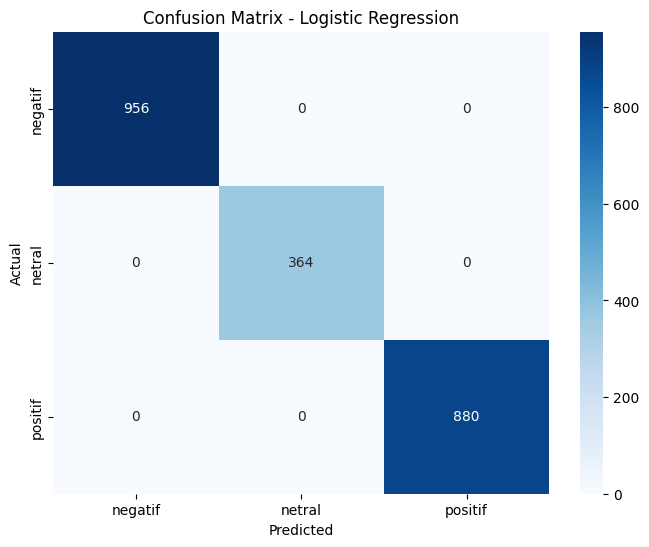

In [19]:
#confusion matrix
# Make sure we're using the correct y_test and y_pred
cm = confusion_matrix(y_test, logistic_model.predict(X_test_combined))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## SKEMA 2: Random Forest + Word2Vec + Rating (80/20)

In [20]:
# SKEMA 2: Random Forest + Word2Vec + Rating (80/20)

# Word2Vec
sentences = [text.split() for text in data['cleaned_review']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def text_to_vector(text):
    words = text.split()
    vec = np.zeros(100)
    count = 0
    for word in words:
        if word in w2v_model.wv:
            vec += w2v_model.wv[word]
            count += 1
    return vec / count if count > 0 else vec


In [21]:
# Gabungkan Word2Vec dan rating
X_w2v = np.array([text_to_vector(text) for text in data['cleaned_review']])
X_combined = np.hstack((X_w2v, data['normalized_rating'].values.reshape(-1, 1)))

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, data['label'], test_size=0.2, stratify=data['label'], random_state=42
)

In [23]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluasi
y_pred = rf_model.predict(X_test)
print("\n=== Random Forest + Word2Vec + Rating ===")
print(classification_report(y_test, y_pred, target_names=['negatif', 'netral', 'positif']))
print("Akurasi:", accuracy_score(y_test, y_pred))



=== Random Forest + Word2Vec + Rating ===
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       956
      netral       1.00      1.00      1.00       364
     positif       1.00      1.00      1.00       880

    accuracy                           1.00      2200
   macro avg       1.00      1.00      1.00      2200
weighted avg       1.00      1.00      1.00      2200

Akurasi: 0.9995454545454545


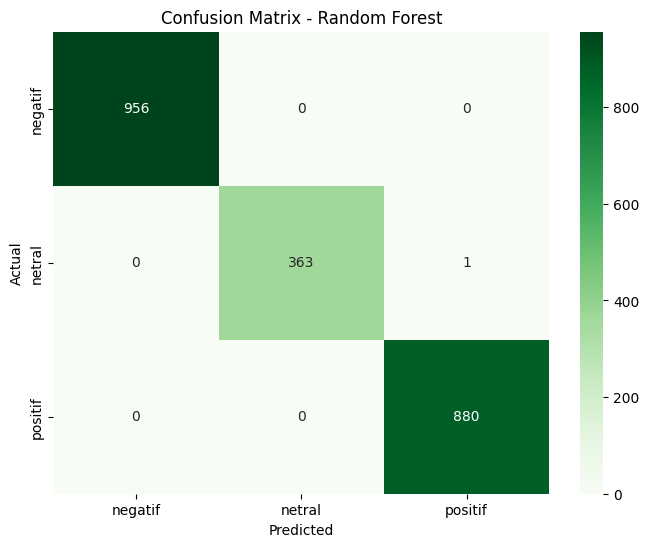

In [24]:
cm = confusion_matrix(y_test, rf_model.predict(X_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
print("Apakah data training dan testing identik:", np.array_equal(X_train_combined.toarray(), X_test_combined.toarray()))


Apakah data training dan testing identik: False


## SKEMA 3: LSTM + Embedding + Rating (70/30)

In [26]:
# SKEMA 3: LSTM + Embedding + Rating (70/30)

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['cleaned_review'])

In [27]:
# Split data
train_texts, test_texts, train_labels, test_labels, train_ratings, test_ratings = train_test_split(
    data['cleaned_review'], data['label'], data['normalized_rating'],
    test_size=0.3, stratify=data['label'], random_state=42
)

In [28]:
train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)


In [29]:
# Sequence dan padding
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
train_padded = pad_sequences(train_sequences, maxlen=150, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=150, padding='post', truncating='post')


In [30]:
# Model LSTM dengan rating

def build_lstm_model():
    # Input teks
    text_input = Input(shape=(150,), name='text_input')
    embedding = Embedding(10000, 128)(text_input)
    lstm = Bidirectional(LSTM(32, return_sequences=False))(embedding)
    dropout = Dropout(0.3)(lstm)

    # Input rating
    rating_input = Input(shape=(1,), name='rating_input')

    # Gabungkan
    concat = concatenate([dropout, rating_input])
    dense = Dense(64, activation='relu')(concat)
    output = Dense(3, activation='softmax')(dense)

    model = Model(inputs=[text_input, rating_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [31]:
# Training
lstm_model = build_lstm_model()
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = lstm_model.fit(
    [train_padded, np.array(train_ratings)],
    train_labels,
    epochs=10,
    validation_data=([test_padded, np.array(test_ratings)], test_labels),
    callbacks=[early_stop]
)

# Evaluasi
test_loss, test_acc = lstm_model.evaluate([test_padded, np.array(test_ratings)], test_labels)
print("\n=== LSTM + Embedding + Rating ===")
print(f"Akurasi: {test_acc:.4f}")


Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7206 - loss: 0.8459 - val_accuracy: 0.8164 - val_loss: 0.5172
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8380 - loss: 0.4310 - val_accuracy: 0.8973 - val_loss: 0.3208
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9292 - loss: 0.2607 - val_accuracy: 0.9424 - val_loss: 0.2380
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9637 - loss: 0.1687 - val_accuracy: 0.9373 - val_loss: 0.2121
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9828 - loss: 0.1055 - val_accuracy: 0.9258 - val_loss: 0.2153
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9892 - loss: 0.0708 - val_accuracy: 0.9294 - val_loss: 0.2022
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9938 - loss: 0.0486 - val_accuracy: 0.9130 - val_loss: 0.2336
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9962 - loss: 0.0336 - val_acc

In [32]:
y_pred = lstm_model.predict([test_padded, np.array(test_ratings)])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=['negatif', 'netral', 'positif']))


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

     negatif       0.93      0.97      0.95      1434
      netral       0.86      0.68      0.76       545
     positif       0.94      0.99      0.96      1321

    accuracy                           0.93      3300
   macro avg       0.91      0.88      0.89      3300
weighted avg       0.93      0.93      0.93      3300



104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


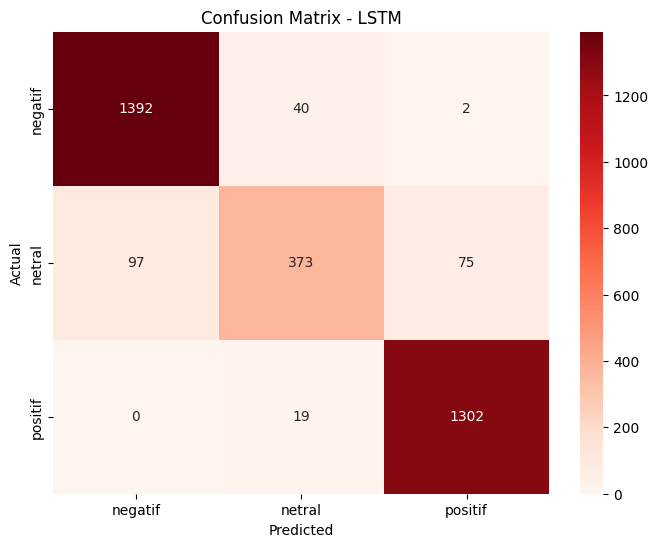

In [33]:
# Add confusion matrix - use the test data from LSTM evaluation
cm = confusion_matrix(np.argmax(test_labels, axis=1),
                     np.argmax(lstm_model.predict([test_padded, np.array(test_ratings)]), axis=1))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Data Size Verification

In [34]:
# ==============================================
# Data Size Verification
# ==============================================
print(f"\nTotal samples in dataset: {len(data)}")
print("Class distribution:")
print(data['sentiment'].value_counts())


Total samples in dataset: 11000
Class distribution:
sentiment
negatif    4781
positif    4402
netral     1817
Name: count, dtype: int64


# Fungsi Inference untuk Semua Model

In [35]:
def predict_sentiment(model_type, text, rating):
    cleaned_text = clean_text(text)
    normalized_rating = rating / 5.0

    if model_type == "logistic":
        text_vector = tfidf.transform([cleaned_text])
        rating_vector = np.array([[normalized_rating]])
        combined = hstack([text_vector, rating_vector])
        pred = logistic_model.predict(combined)[0]
        return ['negatif', 'netral', 'positif'][pred]

    elif model_type == "rf":
        vec = text_to_vector(cleaned_text)
        combined = np.hstack((vec, np.array([normalized_rating])))
        pred = rf_model.predict([combined])[0]
        return ['negatif', 'netral', 'positif'][pred]

    elif model_type == "lstm":
        try:
            # Convert text ke sequence
            seq = tokenizer.texts_to_sequences([cleaned_text])

            # Handle sequences yang kosong
            if not seq or len(seq[0]) == 0:
                seq = [[1]]  # Use index 1 (typically the first real word index)

            # Pad sequence
            padded = pad_sequences(seq, maxlen=150, padding='post', truncating='post')

            # Ensure correct shape and dtype
            padded = np.array(padded, dtype=np.int32).reshape(1, 150)
            rating_array = np.array([[normalized_rating]], dtype=np.float32)

            # Rebuild model inputs explicitly
            inputs = {
                'text_input': padded,
                'rating_input': rating_array
            }

            # Make prediction
            prediction = lstm_model.predict(inputs, verbose=0)
            pred = np.argmax(prediction)
            return ['negatif', 'netral', 'positif'][pred]

        except Exception as e:
            print(f"Error during LSTM prediction: {str(e)}")
            # Fallback to rating-based prediction
            return 'positif' if rating > 3 else 'negatif' if rating < 3 else 'netral'

In [36]:
# Contoh prediksi
print("\n=== Contoh Prediksi ===")
print("LOGISTICT:", predict_sentiment("logistic", "aplikasi buruk", 2))
print("RF:", predict_sentiment("rf", "cukup lumayan", 3))
print("LSTM:", predict_sentiment("lstm", "sangat bagus", 5))



=== Contoh Prediksi ===
LOGISTICT: negatif
RF: netral
LSTM: positif


# saved model



In [42]:
import pickle

# Simpan model
with open("logistic.pkl", "wb") as f:
    pickle.dump(logistic_model, f)  # Ganti logistic_model dengan model Anda

In [43]:
# Simpan TF-IDF Vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

In [44]:
files.download('logistic.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
files.download('tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>